# Problem Statement -
Today the study of financial credit risk assessment attracts increasing attentions in the face of one of the most severe financial crisis ever observed in the world. The accurate assessment of financial credit risk and prediction of business failure play an essential role both on economics and society.

Credit risk management is the practice of mitigating losses by understanding the adequacy of a bank’s capital and loan loss reserves at any given time – a process that has long been a challenge for financial institutions.

The global financial crisis – and the credit crunch that followed – put credit risk management into the regulatory spotlight. As a result, regulators began to demand more transparency. They wanted to know that a bank has thorough knowledge of customers and their associated credit risk. And new Basel III regulations will create an even bigger regulatory burden for banks.

To comply with the more stringent regulatory requirements and absorb the higher capital costs for credit risk, many banks are overhauling their approaches to credit risk. But banks who view this as strictly a compliance exercise are being short-sighted. Better credit risk management also presents an opportunity to greatly improve overall performance and secure a competitive advantage.

# 1) Import libraries/ Dipendancies -

In [2]:
# Importing libraries for Data Manipulation
import pandas as pd
import numpy as np
import json
import pickle

# Libraries which are required for maodel training and Evaluation
from scipy.stats import zscore,mode
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics import precision_score,recall_score,confusion_matrix,precision_recall_curve
from sklearn.metrics import accuracy_score,classification_report,f1_score,roc_curve
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier

# Importing warnings to filter warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

# Importing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as ex
import matplotlib
from IPython.display import display
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
%matplotlib inline

# Importing Libraries to generate pandas Profilling Report
import pandas_profiling
import ydata_profiling
from collections import Counter

# 2) Data Gathering and Data Validitation -¶
Recieved data according to Schema file and got the data. for DQ check we have used Microsoft Excel.

In [3]:
# Reading CSV File -
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


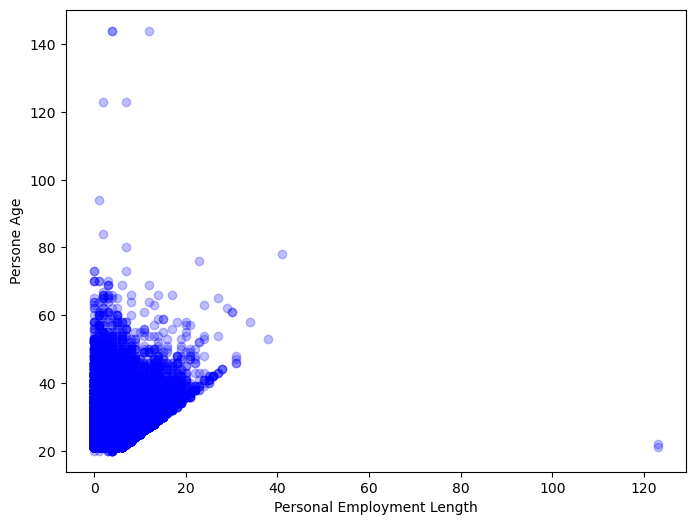

In [4]:
# plots a scatter plot of pesonal employment length against age
plt.figure(figsize=(8, 6))

plt.scatter(df['person_emp_length'], df['person_age'], color='blue', alpha=0.25)
plt.xlabel('Personal Employment Length')
plt.ylabel('Persone Age')

plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

Here we can see the higher correlation between age and income as they are may working from long time in the company, we can also see the outliers in the data. Persons age above 100 years is not feasible in the any sense. the person whoes age is above 100 years he or she not going to apply for loan in any condition. If there is entry of that case then this person is definitely going to default. In case of person employment length above 60 years length is not feasible in the buisness scenario.

In [5]:
# checking for indices of persons employment length grater than 60
indices = df[df["person_emp_length"] > 60].index
indices

Int64Index([0, 210], dtype='int64')

# on the indices 0 and 210 there are ahe outliers so after discussion with buisness experties will remove those. we have got 2 outliers in the data.

In [6]:
# length of records where outliers are present 
len(indices)

2

In [7]:
# Checking for which records will be dropped
df.loc[[0,210]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [8]:
# Dropping the records based on the indices
df_1 = df.drop([0,210],axis=0)
df_1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


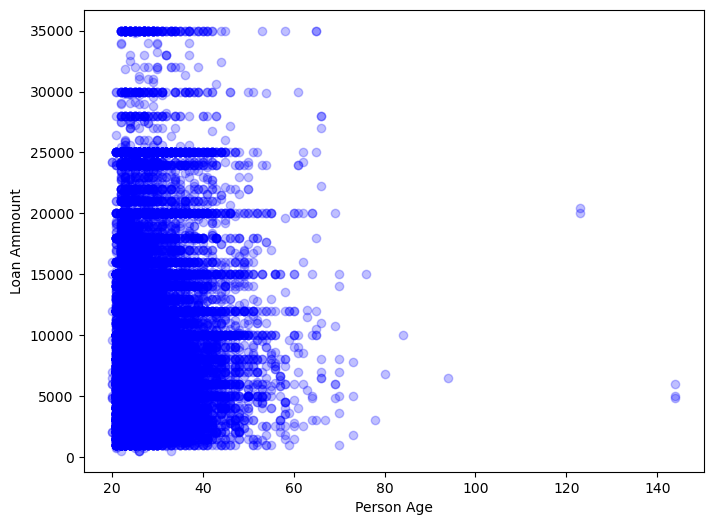

In [9]:
# plots a scatter plot of pesonal employment length against age
plt.figure(figsize=(8,6))
plt.scatter(df_1["person_age"],df_1["loan_amnt"],color = "blue",alpha=0.25)
plt.xlabel("Person Age")
plt.ylabel("Loan Ammount")
plt.show()

We discovered outliers in person_emp_length where values greater than 60 were far above the norm. person_age is another column in which a person can use a common sense approach to say it is very unlikely that a person applying for a loan will be over 100 years old.

In [10]:
# checking for indices of persons employment length grater than 100
indices = df_1[df_1["person_age"] > 100].index
indices

Int64Index([81, 183, 575, 747, 32297], dtype='int64')

In [11]:
# we are dropping those Entries from df and creating new df
df_2 = df_1.drop([81, 183, 575, 747, 32297],axis=0)
df_2.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


# 3) EDA (Exploratory Data Analysis) -

Steps Involved in EDA - 
    1) Information about Datset
    2) Describe Dataset
    3) Find Missing Values / Percentage of Missing Values
    4) Value Counts of Each Object Feature
    4) Desciding Encoding Types
    5) Outliers Detection
    6) Correlation with Target Feature
    7) VIF (Variance Inflation Factor)
    8) Status of Target Feature
    9) EDA report

# Information about Datset

In [12]:
# Checking information of dataset
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32574 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               29459 non-null  float64
 8   loan_status                 32574 non-null  int64  
 9   loan_percent_income         32574 non-null  float64
 10  cb_person_default_on_file   32574 non-null  object 
 11  cb_person_cred_hist_length  32574 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


 Here we have got basic information about data like non null count, memory usage and Data type of Features. there are missing values in the person_emp_length and loan_int_rate. there are 4 object features which are person_home_ownership, loan_intent, loand_grade and cb_person_default_on_file.



# Describe Dataset

In [15]:
# Here we are printing Description of dataset and got all the stats.
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32574.0,27.718426,6.204987,20.00,23.00,26.00,30.00,94.00
person_income,32574.0,65878.480813,52531.938809,4000.00,38500.00,55000.00,79200.00,2039784.00
person_emp_length,31679.0,4.782064,4.034948,0.00,2.00,4.00,7.00,41.00
loan_amnt,32574.0,9588.018051,6320.249598,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29459.0,11.011529,3.240497,5.42,7.90,10.99,13.47,23.22
loan_status,32574.0,0.218180,0.413017,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32574.0,0.170202,0.106755,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32574.0,5.804108,4.053873,2.00,3.00,4.00,8.00,30.00


In [14]:
# creates a cross table of the loan intent and loan status
pd.crosstab(df_2['loan_intent'], df_2['loan_status'], margins=True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5340,1111,6451
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4422,1097,5519
VENTURE,4869,847,5716
All,25467,7107,32574


# As observed:

- VENTURE has the least number of defaults while MEDICAL has the most.
- EDUCATION and MEDICAL are the greatest loan intents while HOMEIMPROVEMENT is the least.
- MEDICAL and DEBTCONSOLIDATION are the intents where there are more defaults.`
- Find Missing Values / Percentage of Missing Values

In [16]:
# Count of Missing Values in Each Numerical Feature 
df_2.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [17]:
# Percentage of Missing Values in Each Numerical Feature
df_2.isna().mean() * 100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747590
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.562842
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

- As we See above list There are Missing values in person_emp_length and loan_int_rate features.   Missing data within person_emp_length would not be as damaging, but would still cause training   errors.

- Person_emp_length Feature -

- Values = 895 and Percentage = 2.747590
- Loan_int_rate Feature -

- Values = 3115 and Percentage = 9.562842
- Value Counts of Each Object Feature

# Value Counts of Each Object Feature

In [18]:
# Here we are checking for the Value counts of each Object datatype features.
cols = df_2.select_dtypes(include="object").columns.to_list()
for feature in cols:
    print("Column Name - ",feature)
    print(df[feature].value_counts().sort_values(ascending=False))
    print()

Column Name -  person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64

Column Name -  loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

Column Name -  loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64

Column Name -  cb_person_default_on_file
N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64



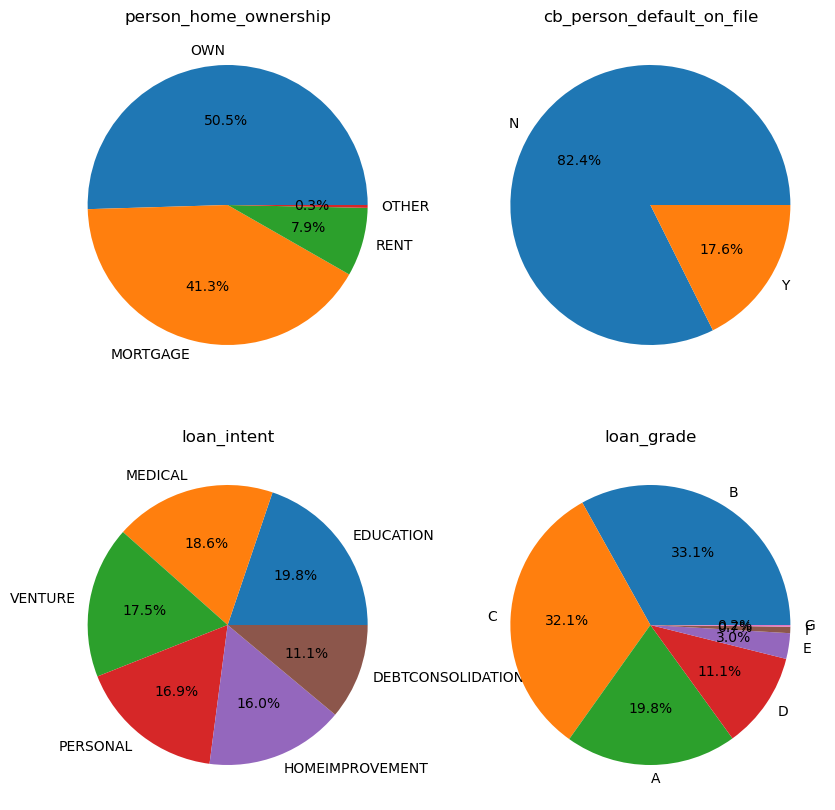

In [19]:
# Pie plot of Value counts in the feature Person_home_ownership,loan_intent,cb_person_default_on_file and loan_grade
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
line1 = plt.pie(df_2["person_home_ownership"].value_counts(),labels = df_2["person_home_ownership"].unique(),autopct="%1.1f%%")
plt.title('person_home_ownership')
ax1 = fig.add_subplot(223)
line2 = plt.pie(df_2["loan_intent"].value_counts(),labels = df_2["loan_intent"].unique(),autopct="%1.1f%%")
plt.title('loan_intent')
ax1 = fig.add_subplot(222)
line3 = plt.pie(df_2["cb_person_default_on_file"].value_counts(),labels = df_2["cb_person_default_on_file"].unique()
                ,autopct="%1.1f%%")
plt.title('cb_person_default_on_file')
ax1 = fig.add_subplot(224)
line4 = plt.pie(df_2["loan_grade"].value_counts(),labels = df_2["loan_grade"].unique(),autopct="%1.1f%%")
plt.title('loan_grade')
plt.show()

- Targetting 4 Object Datatype feature which are person_home_ownership,loan_intent,loan_grade and   cb_person_default_on_file. We are checking for distribution of Data from Those Features.

- Column Name - person_home_ownership

- RENT = 16446 (7.9%)
- MORTGAGE = 13444 (41.3%)
- OWN = 2584 (50.5%)
- OTHER = 107 (0.3%)
- Column Name - loan_intent

- EDUCATION = 6453 (19.8%)
- MEDICAL = 6071 (18.6%)
- VENTURE = 5719 (17.5%)
- PERSONAL = 5521 (16.9%)
- DEBTCONSOLIDATION = 5212 (11.1%)
- HOMEIMPROVEMENT = 3605 (16.0%)
- Column Name - loan_grade

A = 10777 (19.8%)
B = 10451 (33.1%)
C = 6458 (32.1%)
D = 3626 (11.1%)
E = 964 (3.0%)
F = 241 (0.7%)
G = 64 (0.2%)
Column Name - cb_person_default_on_file

N = 26836 (82.4%)
Y = 5745 (17.6%)

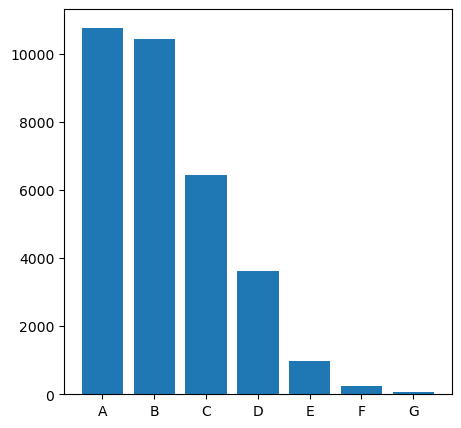

In [20]:
# bar graph of Value counts in the feature loan-grade
dict1 = df_2["loan_grade"].value_counts().to_dict()
x1 = list(dict1.keys())
y1 = list(dict1.values())
plt.figure(figsize=(5,5))
plt.bar(x1,y1)
plt.show()

Desciding Encoding Types

In [21]:
# Checking for any sequence is the object columns so we can select encoding techniques.
cols = df_2.select_dtypes(include="object").columns.to_list()
for feature in cols:
    print("Column Name - ",feature)
    print(df_2[feature].unique())
    print()

Column Name -  person_home_ownership
['OWN' 'MORTGAGE' 'RENT' 'OTHER']

Column Name -  loan_intent
['EDUCATION' 'MEDICAL' 'VENTURE' 'PERSONAL' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

Column Name -  loan_grade
['B' 'C' 'A' 'D' 'E' 'F' 'G']

Column Name -  cb_person_default_on_file
['N' 'Y']



- Here we can clearely see there is no any precedence or sequence in the person_home_ownership, loan_intent and loan_grade Features so we have to use either get_dummies() or OneHotEncoding Technique.

- Features for OneHotEncoding / Get Dummies - person_home_ownership, loan_intent, loan_grade
Here we can clearely see there is precedence or sequence in the cb_person_default_on_file Feature so we have to use either replace() or Ordinal Encoding Technique.

- Features for OrdinalEncoding / replace - cb_person_default_on_file
As there are numerical values in the loan_status feature i.e Target Feature so we doesnt require need of Label Encoding Technique



# Outliers Detection

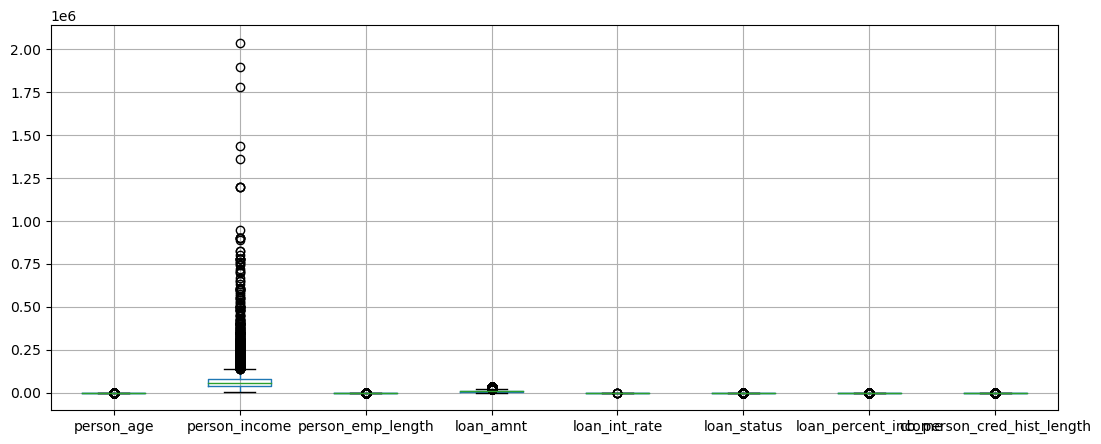

In [22]:
# Here we can see there ae outliers in the every feature
plt.figure(figsize=(13,5))
df_2.boxplot()
plt.show()

Here we can clearly see the outliers in the each and every column so we have to check for each columns Separately. We have to check especially for person_income feature because there are extreme outliers in that feature ata first glance.

<AxesSubplot:xlabel='person_age'>

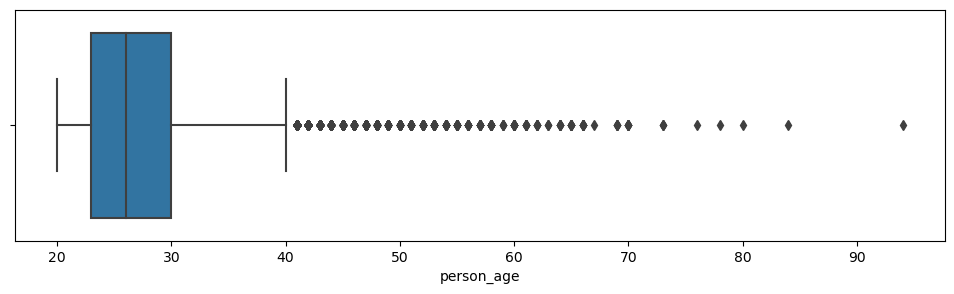

In [23]:
# Checking of outliers in person_age Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["person_age"])

In [24]:
# Count of outliers in person_age by using Z-score method
z = zscore(df_2["person_age"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in person_age - {len(z1)}")

Count of Outliers in person_age - 553


Here we can say practically age more than 100 is not possible so those are outliers. Values present in the feature person_age are now not trated as outliers because commonly persons live between 0 to 100 years. We have dealed Extreme outliers before.

<AxesSubplot:xlabel='person_income'>

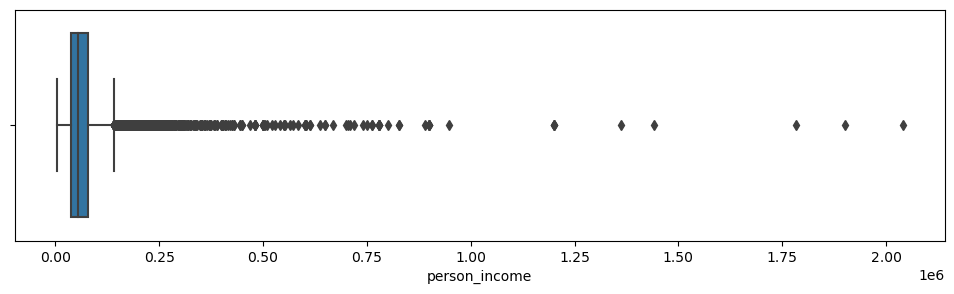

In [25]:
# Checking of outliers in person_income Feature, we can see there is one extreme outlier
# we are not considering 558 are outliers because person can live upto 120 years.
plt.figure(figsize=(12,3))
sns.boxplot(df_2["person_income"])

In [26]:
# Count of outliers in person_income by using Z-score method
z = zscore(df_2["person_income"]).to_list()
z2 = []
for i in z:
    if i > 3 or i <-3:
        z2.append(i)
print(f"Count of Outliers in person_income - {len(z2)}")

Count of Outliers in person_income - 355


In [27]:
# Count of Outliers using iqr method to crosscheck the above result.
q1 = df_2["person_income"].quantile(0.25)
q3 = df_2["person_income"].quantile(0.75)
iqr = q3 - q1
upper_tail = q3 + 1.5 * iqr
lower_tail = q1 - 1.5 * iqr
print(f"Upper tail - {upper_tail}\nLower tail - {lower_tail}")
count = df_2.loc[(df_2["person_income"] > upper_tail) | (df_2["person_income"] < lower_tail)].shape[0]
print(f"Count of Outliers in person_income - {count}")

Upper tail - 140250.0
Lower tail - -22550.0
Count of Outliers in person_income - 1480


person_income in this column there are 1480 outliers by IQR method and there are also extreme outliers in this Feature.

<AxesSubplot:xlabel='person_emp_length'>

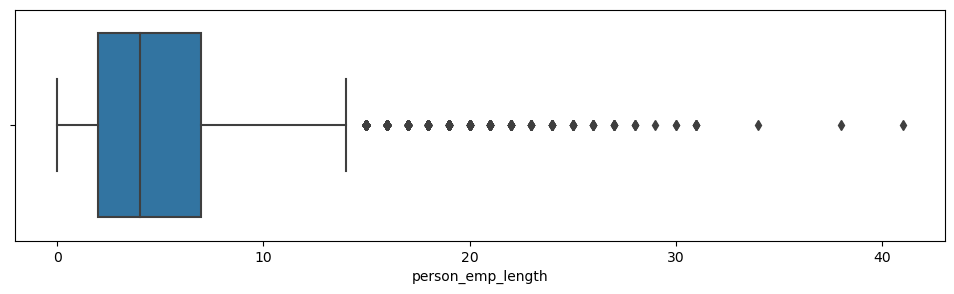

In [28]:
# Checking of outliers in person_emp_length Feature,we can see there is one extreme outlier.
plt.figure(figsize=(12,3))
sns.boxplot(df_2["person_emp_length"])

In [29]:
# Count of outliers in person_emp_length by using Z-score method, here z-score is showing
z = zscore(df_2["person_emp_length"]).to_list()
z1 = []
for i in z:
    if i > 3 or i < -3:
        z1.append(i)
print(f"Count of Outliers in person_emp_length - {len(z1)}")

Count of Outliers in person_emp_length - 0


In [30]:
# Count of Outliers using iqr method to crosscheck the above result.
q1 = df_2["person_emp_length"].quantile(0.25)
q3 = df_2["person_emp_length"].quantile(0.75)
iqr = q3 - q1
upper_tail = q3 + 1.5 * iqr
lower_tail = q1 - 1.5 * iqr
print(f"Upper tail - {upper_tail}\nLower tail - {lower_tail}")
count = df_2.loc[(df_2["person_emp_length"] > upper_tail) | (df_2["person_emp_length"] < lower_tail)].shape[0]
print(f"Count of Outliers in person_emp_length - {count}")

Upper tail - 14.5
Lower tail - -5.5
Count of Outliers in person_emp_length - 851


We have Dropped Outliers in this Feature Earlier at the start So according to Z-Score method. This Column is Free from outliers.

<AxesSubplot:xlabel='loan_amnt'>

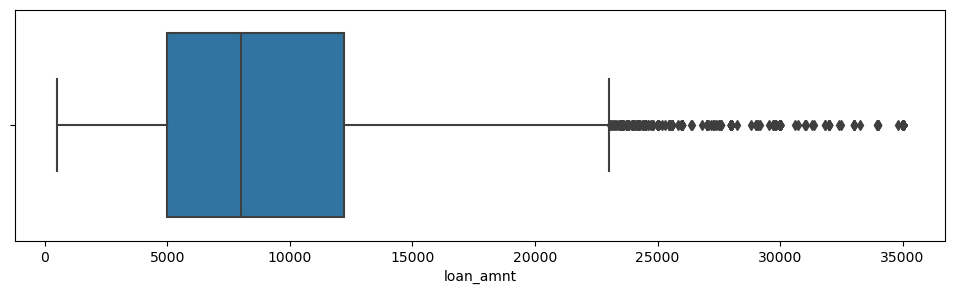

In [31]:
# Checking of outliers in loan_amnt Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["loan_amnt"])

In [32]:
# Count of outliers in loan_amnt by using Z-score method
z = zscore(df_2["loan_amnt"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in loan_amnt - {len(z1)}")

Count of Outliers in loan_amnt - 336


<AxesSubplot:xlabel='loan_int_rate'>

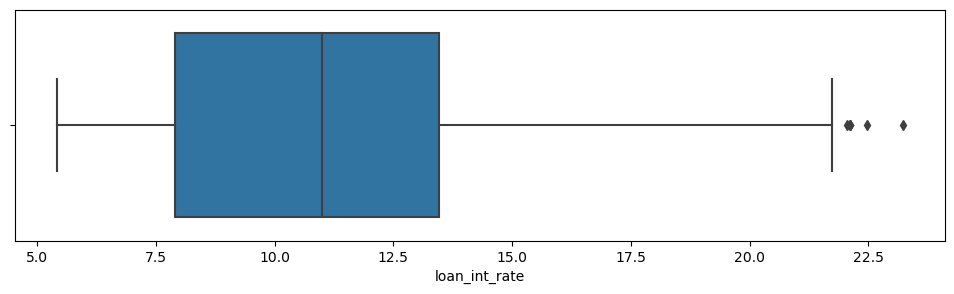

In [33]:
# Checking of outliers in loan_int_rate Feature, Too few outliers in data.
plt.figure(figsize=(12,3))
sns.boxplot(df_2["loan_int_rate"])

In [34]:
# Count of outliers in loan_int_rate by using Z-score method
z = zscore(df_2["loan_int_rate"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in loan_int_rate - {len(z1)}")

Count of Outliers in loan_int_rate - 0


In [36]:
# Count of Outliers using iqr method to crosscheck the above result.
q1 = df_2["loan_int_rate"].quantile(0.25)
q3 = df_2["loan_int_rate"].quantile(0.75)
iqr = q3 - q1
upper_tail = q3 + 1.5 * iqr
lower_tail = q1 - 1.5 * iqr
print(f"Upper tail - {upper_tail}\nLower tail - {lower_tail}")
count = df_2.loc[(df_2["loan_int_rate"] > upper_tail) | (df_2["loan_int_rate"] < lower_tail)].shape[0]
print(f"Count of Outliers in person_income - {count}")

Upper tail - 21.825000000000003
Lower tail - -0.45500000000000007
Count of Outliers in person_income - 6


So according to Z-Score method there are no Outliers in the loan_int_rate Feature. We can also See visually there are few outliers but which are to close to the Upper tail

<AxesSubplot:xlabel='loan_percent_income'>

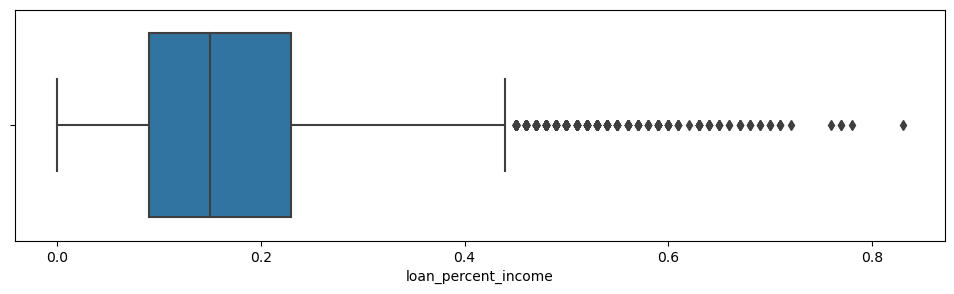

In [37]:
# Checking of outliers in loan_percent_income Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["loan_percent_income"])

In [38]:
# Count of outliers in loan_percent_income by using Z-score method
z = zscore(df_2["loan_percent_income"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in loan_percent_income - {len(z1)}")

Count of Outliers in loan_percent_income - 335


<AxesSubplot:xlabel='cb_person_cred_hist_length'>

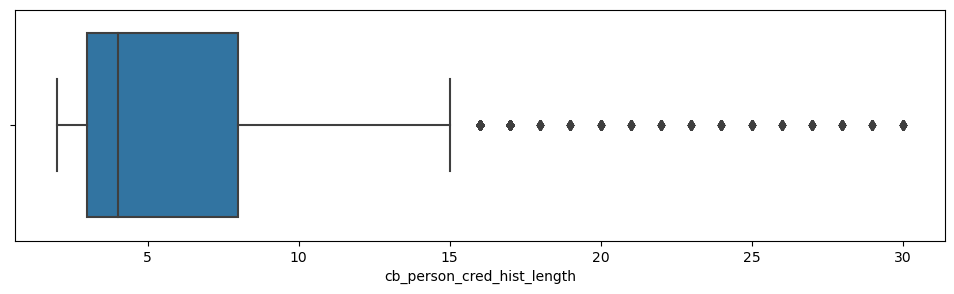

In [39]:
# Checking of outliers in cb_person_cred_hist_length Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["cb_person_cred_hist_length"])

In [40]:
# Count of outliers in cb_person_cred_hist_length by using Z-score method
z = zscore(df_2["cb_person_cred_hist_length"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in cb_person_cred_hist_length - {len(z1)}")

Count of Outliers in cb_person_cred_hist_length - 283


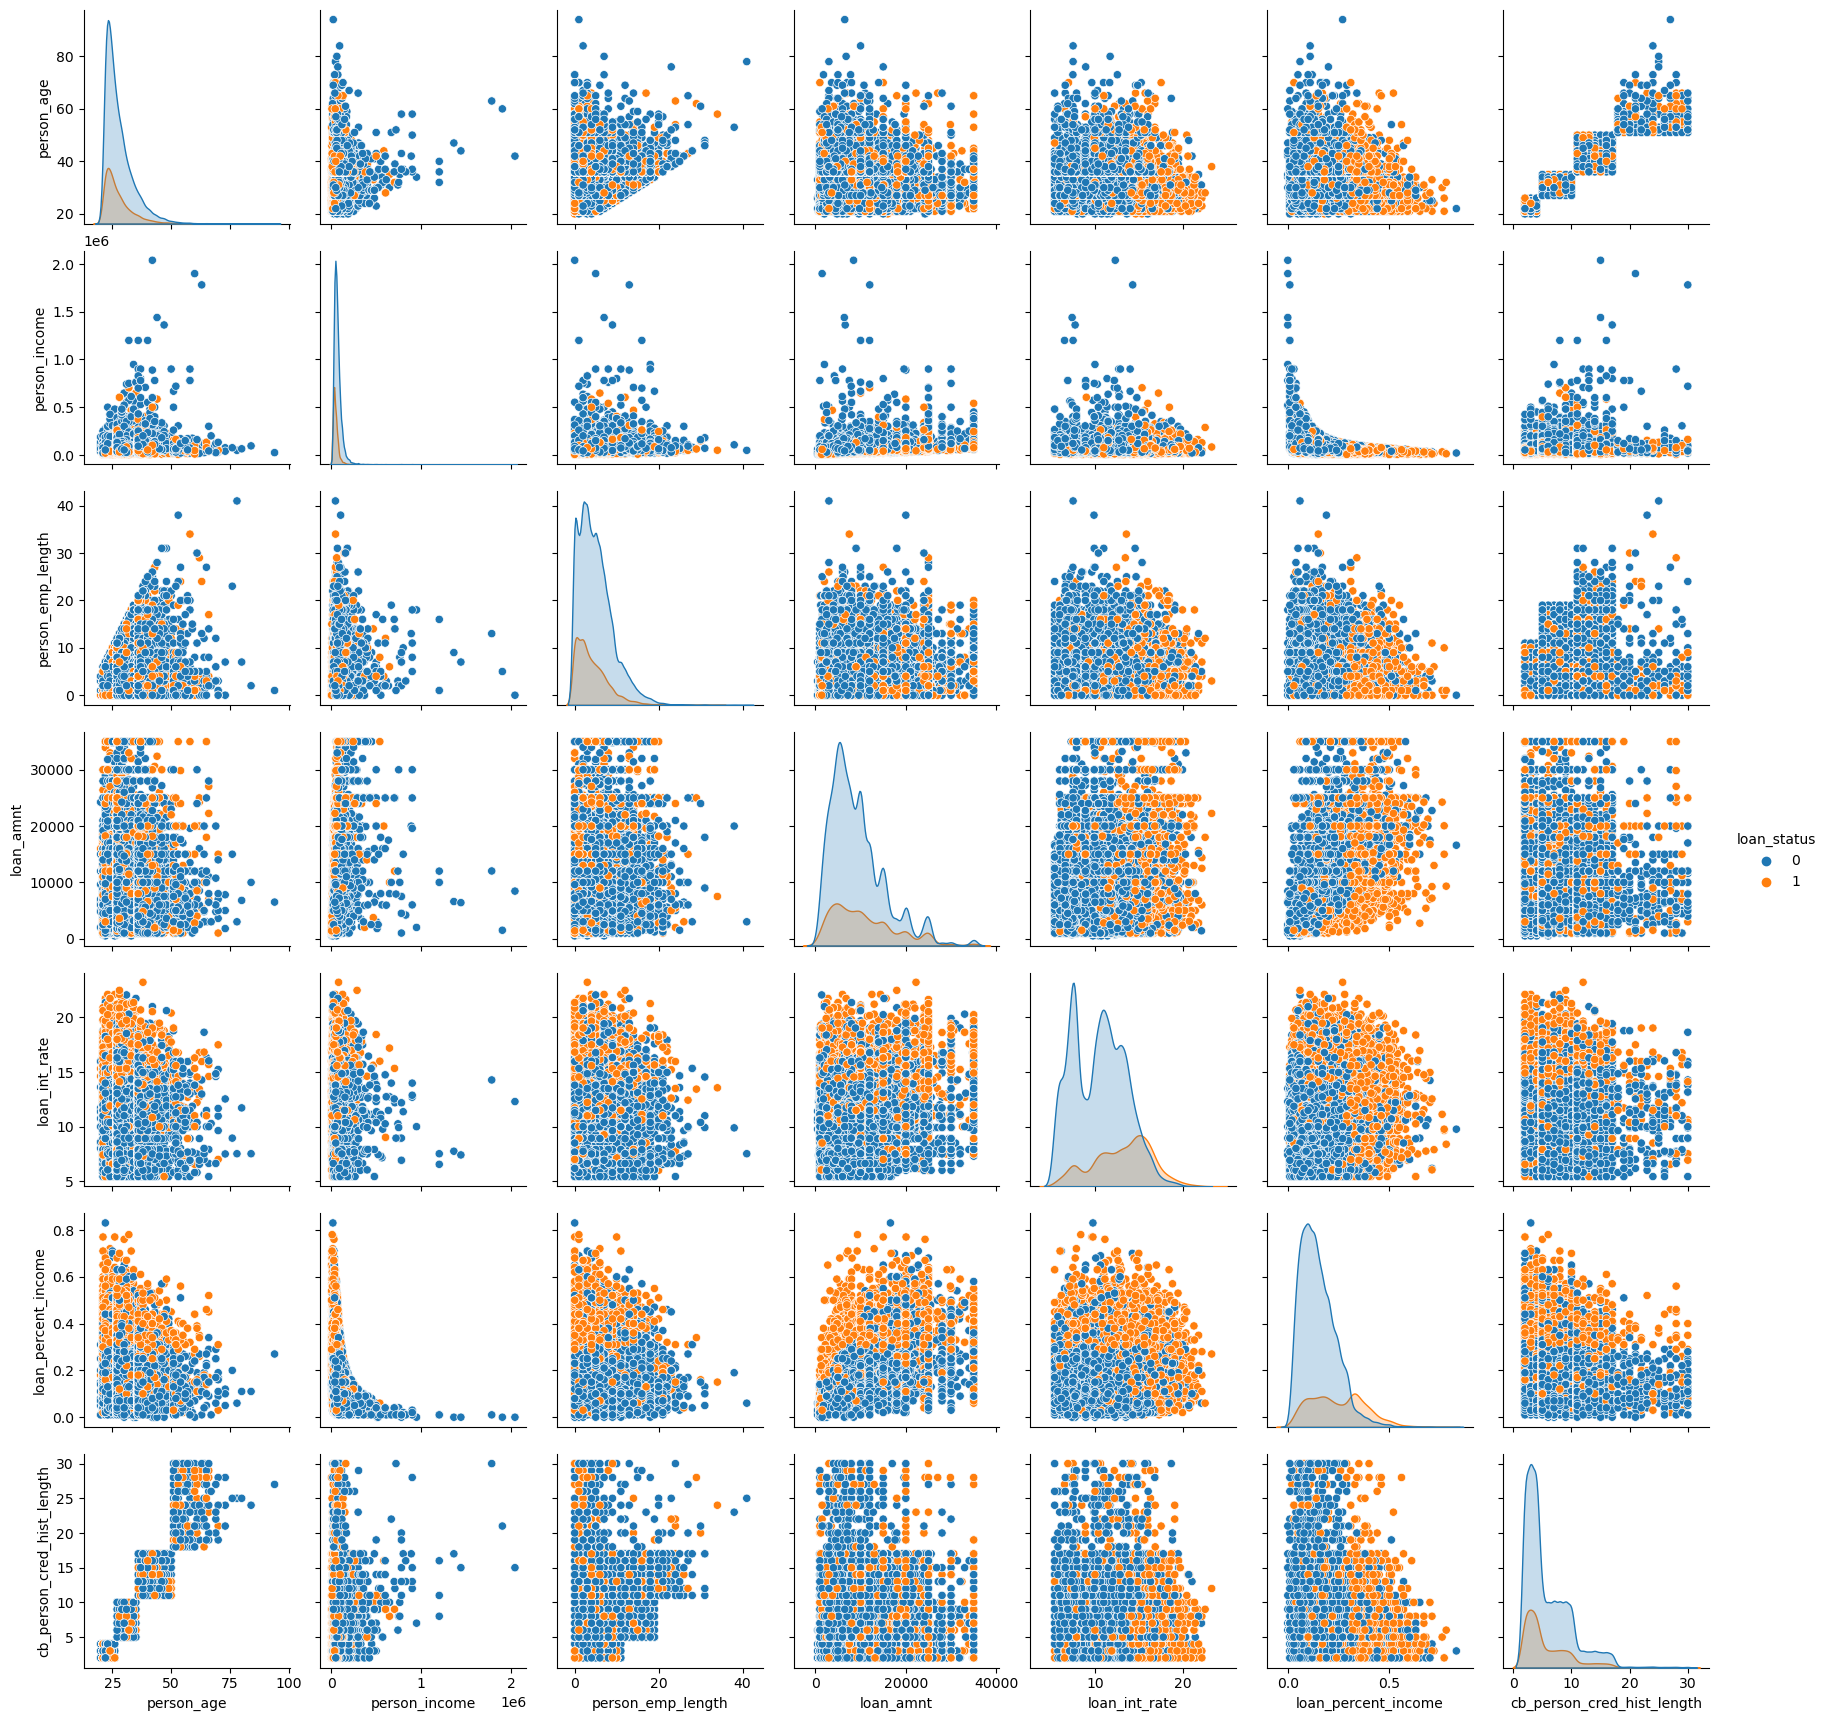

In [41]:
# Pairplot for Distribution
sns.pairplot(df_2,hue="loan_status")

- Correlation with Target Feature

In [42]:
# Checking for correlation of independent feature with dependent features and and we are not getting good correlation.
df_2.corr()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.140497,0.172554,0.051751,0.011966,-0.020687,-0.041587,0.878094
person_income,0.140497,1.000000,0.154746,0.317497,-0.001121,-0.168485,-0.294558,0.123049
person_emp_length,0.172554,0.154746,1.000000,0.110993,-0.058263,-0.085966,-0.058559,0.149404
loan_amnt,0.051751,0.317497,0.110993,1.000000,0.146803,0.105240,0.572420,0.042240
loan_int_rate,0.011966,-0.001121,-0.058263,0.146803,1.000000,0.335092,0.120218,0.016656
loan_status,-0.020687,-0.168485,-0.085966,0.105240,0.335092,1.000000,0.379250,-0.015472
loan_percent_income,-0.041587,-0.294558,-0.058559,0.572420,0.120218,0.379250,1.000000,-0.031447
cb_person_cred_hist_length,0.878094,0.123049,0.149404,0.042240,0.016656,-0.015472,-0.031447,1.000000


In [43]:
# Checking for correlation
df2 = df_2.corr().iloc[5,:].to_frame().T
df2

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
loan_status,-0.020687,-0.168485,-0.085966,0.10524,0.335092,1.0,0.37925,-0.015472


<AxesSubplot:>

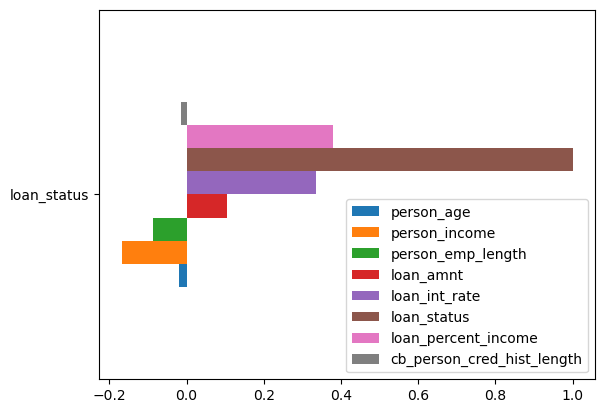

In [44]:
# bar plot of correlation of Loans status feature with respect to all independent features. 
df2.plot(kind="barh")

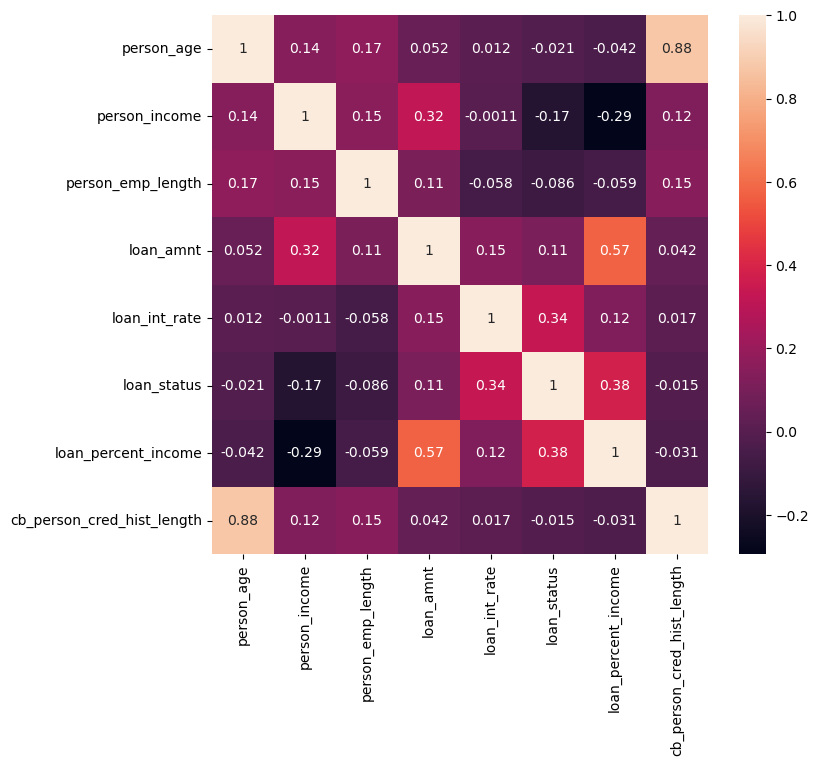

In [45]:
# Heatmap for correlation Values
plt.figure(figsize=(8,7))
sns.heatmap(df_2.corr(),annot=True)
plt.show()

Range of Good correlation/Predictors is -0.7 to -1 for negative correlation and 0.7 to 1 for positive correlation. from above table,heatmap and horrizontal Bar graph there is no one feature which is best Describing the target Feature and almost all features having Worst correlation. which is in between -0.3 to 0.3. We can also say that -

person_age is highly overall correlated with cb_person_cred_hist_length
loan_amnt is highly overall correlated with loan_percent_income
loan_int_rate is highly overall correlated with loan_grade
loan_percent_income is highly overall correlated with loan_amnt
cb_person_cred_hist_length is highly overall correlated with person_age
loan_grade is highly overall correlated with loan_int_rate
cb_person_default_on_file is highly overall correlated with loan_int_rate

VIF (Variance Inflation Factor)

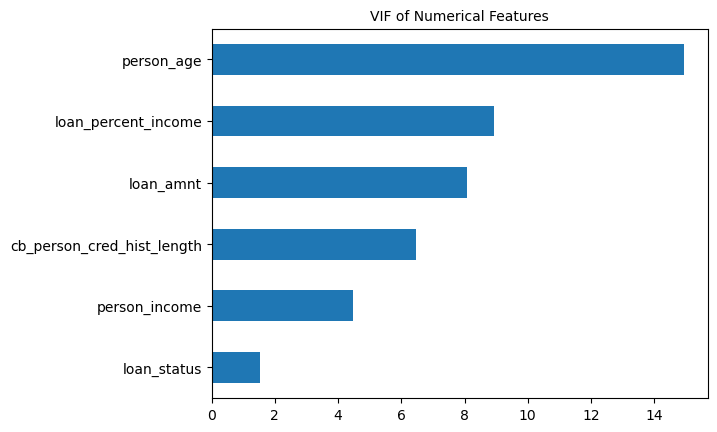

In [46]:
 #Checking for relation between independent features. Here im dropping Features having null values
x = df_2.select_dtypes(exclude="object").drop(["loan_int_rate","person_emp_length"],axis=1)
vif_list = []
for i in range(x.shape[1]):
    vif = variance_inflation_factor(x.to_numpy(),i)
    vif_list.append(vif)
x1 = pd.Series(vif_list,index=x.columns)
x1.sort_values().plot(kind="barh")
plt.title("VIF of Numerical Features",fontsize=10)
plt.show()

Variance inflation factors range is 0 to infinity. 0 to 5 vif score it suggests that there is no correlation between other independent features. If VIF sore is more than 5 then we cut off that feature but in this case most of the features are above vif range so we are not removing any feature.

# Status of Target Feature

First of all We dont require label encoding beacuse target column is actually in numerical datatype. In this case 0 is Non Default Loan Status and 1 is Default Loan Status.

In [47]:
# Checking for Value counts of loan_status feature
df_2["loan_status"].value_counts()

0    25467
1     7107
Name: loan_status, dtype: int64

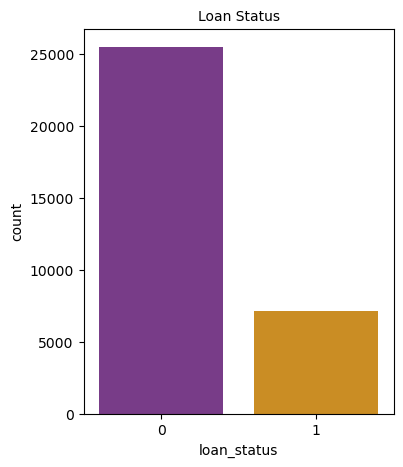

In [48]:
# Countplot of loan Status Feature
plt.figure(figsize=(4,5))
sns.countplot(df_2["loan_status"], palette='CMRmap')
plt.title("Loan Status",fontsize=10)
plt.show()

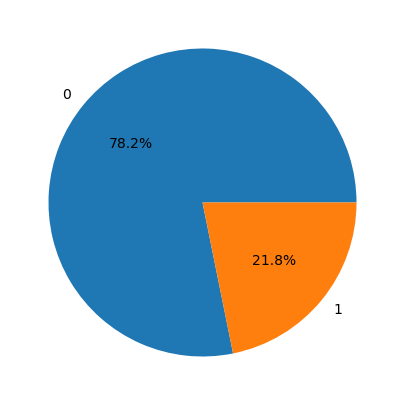

In [49]:
# pie of loan Status Feature so we can check distribution.
plt.figure(figsize=(5,5))
plt.pie(df_2["loan_status"].value_counts(),labels=df_2["loan_status"].unique()
        ,autopct="%1.1f%%")
plt.show()

So here we also got to know that there is bias in the categories so we have to perform sampling on it. Major category contains 78.2 percent of data in the Non Default loan Status category and minor category contains 21.8 percent data in Default loan Status Category.

Number of default cases: 6463 This is equivalent to 21.94% of the total loans

Number of non-defualt cases: 22996 This is equivalent to 78.06% of the total loans

- EDA Report using Pandas Profilling

In [ ]:
# Creating pandas Profiling Report
pf = pandas_profiling.ProfileReport(df_2)
pf.to_widgets()

In [ ]:
# Saving Pandas Profilling Report in the html format.
pf.to_file("EDA Report.html")

### 4) Making Hypothesis for Testing

Defining Hypothesis features wise by taking consideration the insights of above EDA part - 

#### person_age -

- More defaults for the younger peoples

#### person_income -

- People who defult have less income than people who have not default

#### person_home_ownership -

- Mortgage have more cases of default followed by rent and own

#### person_emp_length - 

- There are fewer people of default after long employment term

#### loan_intent -

There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.
least cases of default for venture

#### loan_grade -

There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.
least cases of default for venture

#### loan_grade -

The higher the grade there are fewer cases of default

#### loan_amnt -

- Median of ammount for non default is lower than median for default.

#### loan_int_rate - 

- Higher the intrest rate there higher defaults.

#### loan_percent_income -

People who allocate higher percentage of income to the loan tend to default more than people who allocate less.

#### cb_person_default_on_file - 

There are more cases of default those have default on file

cb_person_cred_hist_length -

There are fewer cases of default those have higher credit history length.

# Hypothesis Testing¶

# Univariate Analysis -

#### Numerical Variables -

In [50]:
# creating a dataset for numerical attributes/features
num = df_2.select_dtypes(include=['int64', 'float64'])
num.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
1,21,9600,5.0,1000,11.14,0,0.10,2
2,25,9600,1.0,5500,12.87,1,0.57,3
3,23,65500,4.0,35000,15.23,1,0.53,2
4,24,54400,8.0,35000,14.27,1,0.55,4
5,21,9900,2.0,2500,7.14,1,0.25,2


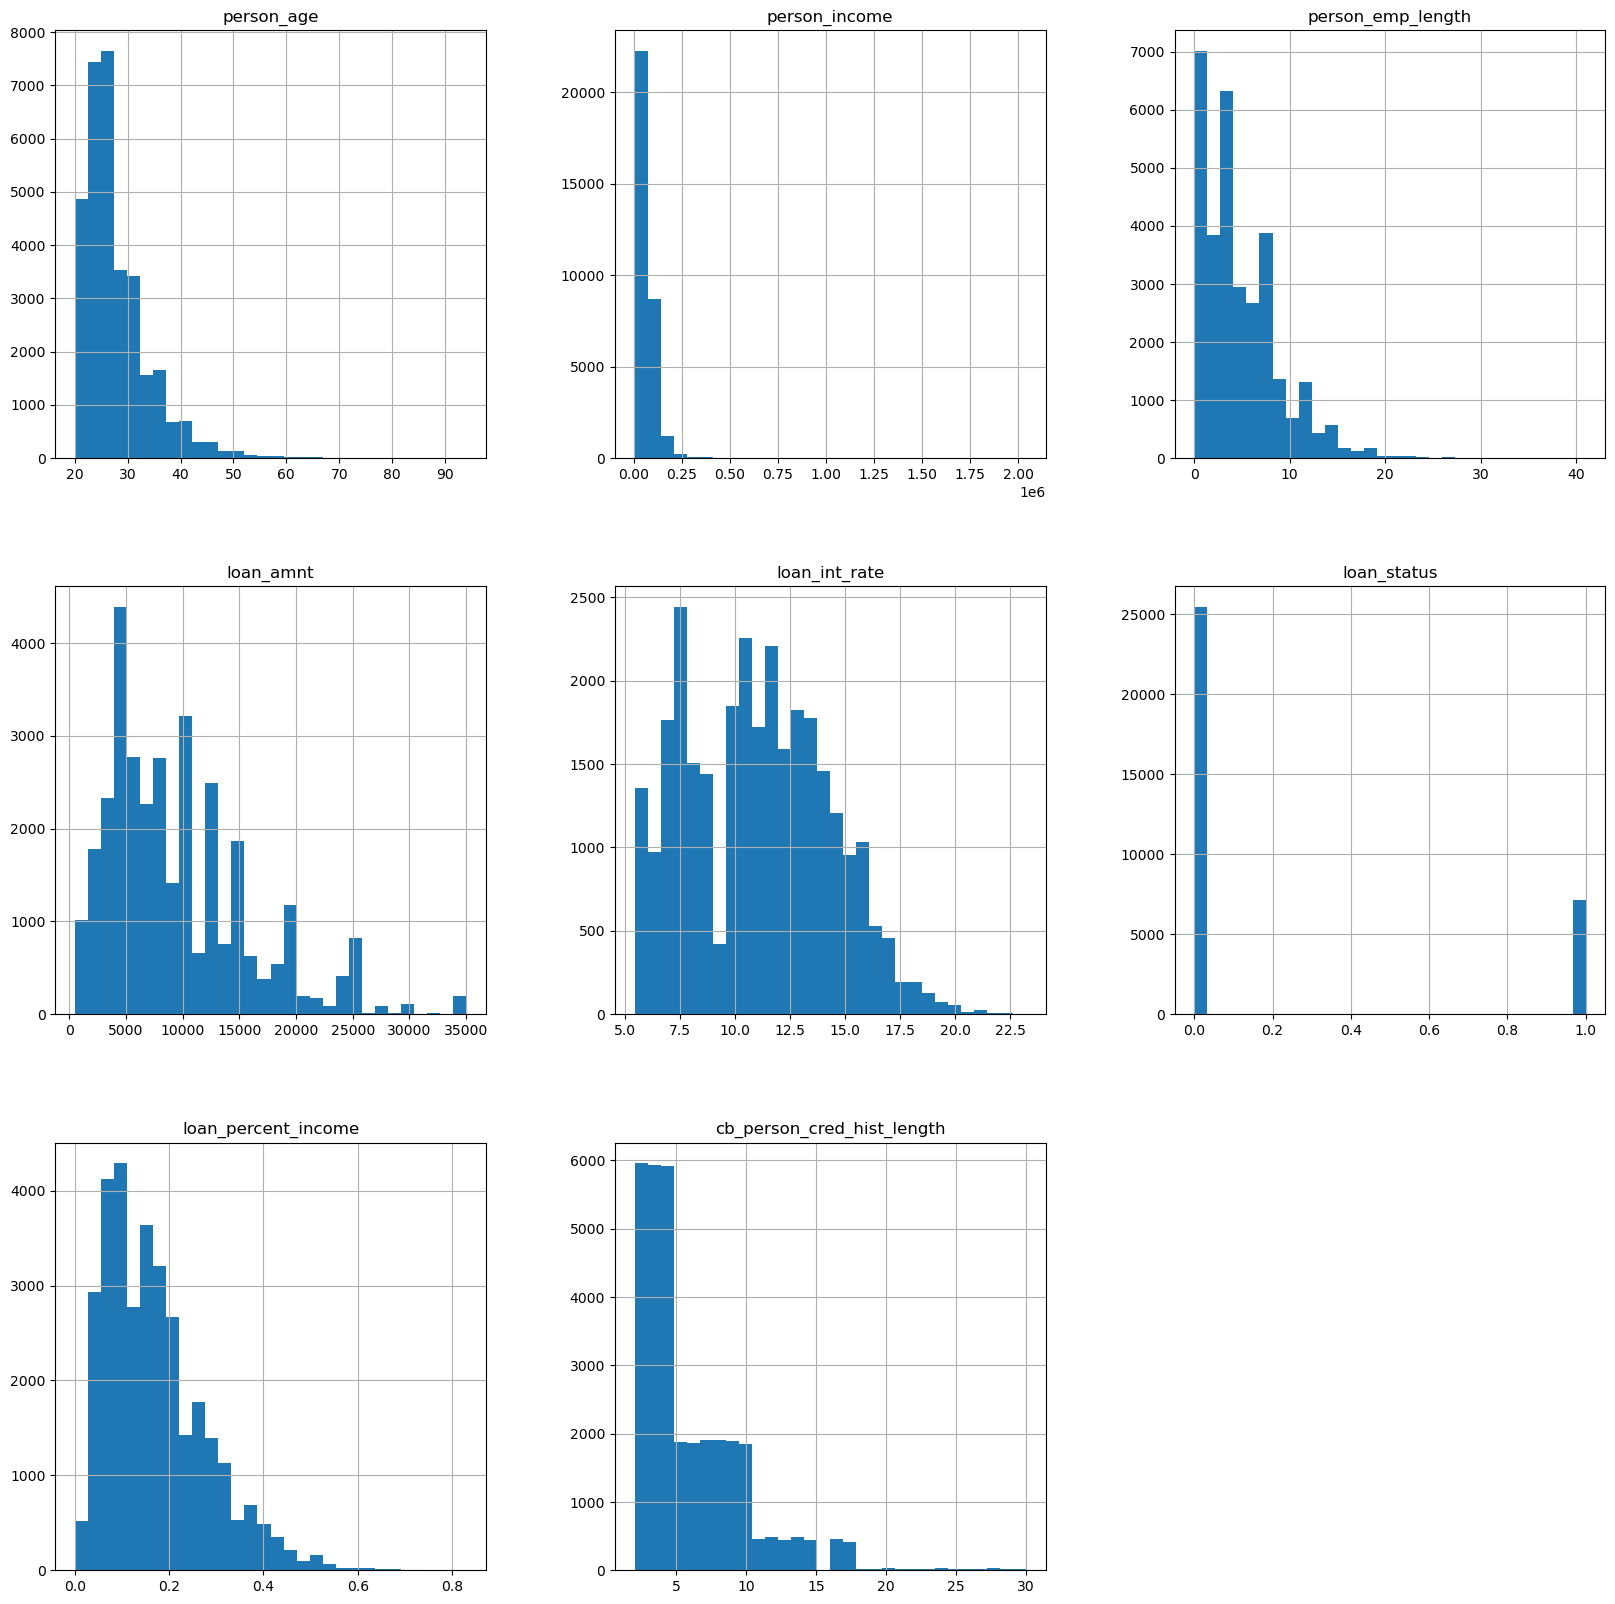

In [51]:
# plots a histogram for all numerical attributes
_ = num.hist(bins=30,figsize=(20,20))

As we can observe, there is no variable that presents a normal distribution. Note that here, we're only exploring the data, not making any handling or transformation.

Categorical Variables -

In [52]:
# Creating a dataset for Categorical Features -
catego = df_2.select_dtypes(include="object")
catego.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y
5,OWN,VENTURE,A,N


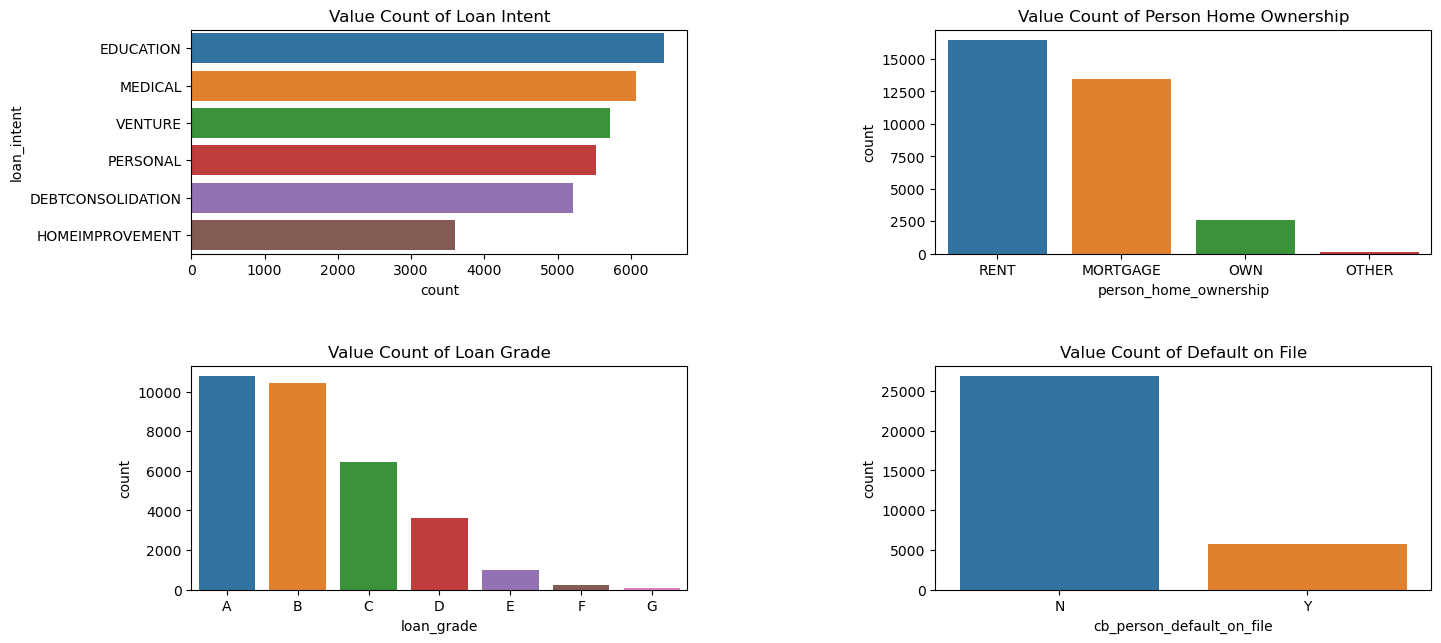

In [53]:
# Charts to show Distribution or count of unique values in Categorical featues
fig, ax = plt.subplots()
ax.figure.set_size_inches(16,16)

plt.subplot(4,2,1)
sns.countplot(y=catego["loan_intent"],order=catego["loan_intent"].value_counts().index)
plt.title("Value Count of Loan Intent")

plt.subplot(4,2,2)
sns.countplot(x=catego["person_home_ownership"],order=catego["person_home_ownership"].value_counts().index)
plt.title("Value Count of Person Home Ownership")

plt.subplot(4,2,3)
sns.countplot(x=catego["loan_grade"],order=catego["loan_grade"].value_counts().index)
plt.title("Value Count of Loan Grade")

plt.subplot(4,2,4)
sns.countplot(x=catego["cb_person_default_on_file"],order=catego["cb_person_default_on_file"].value_counts().index)
plt.title("Value Count of Default on File")

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.5)
plt.show()

# Bivariate analysis - Hypothesis Validation¶

# 1) More defaults for the younger peoples -

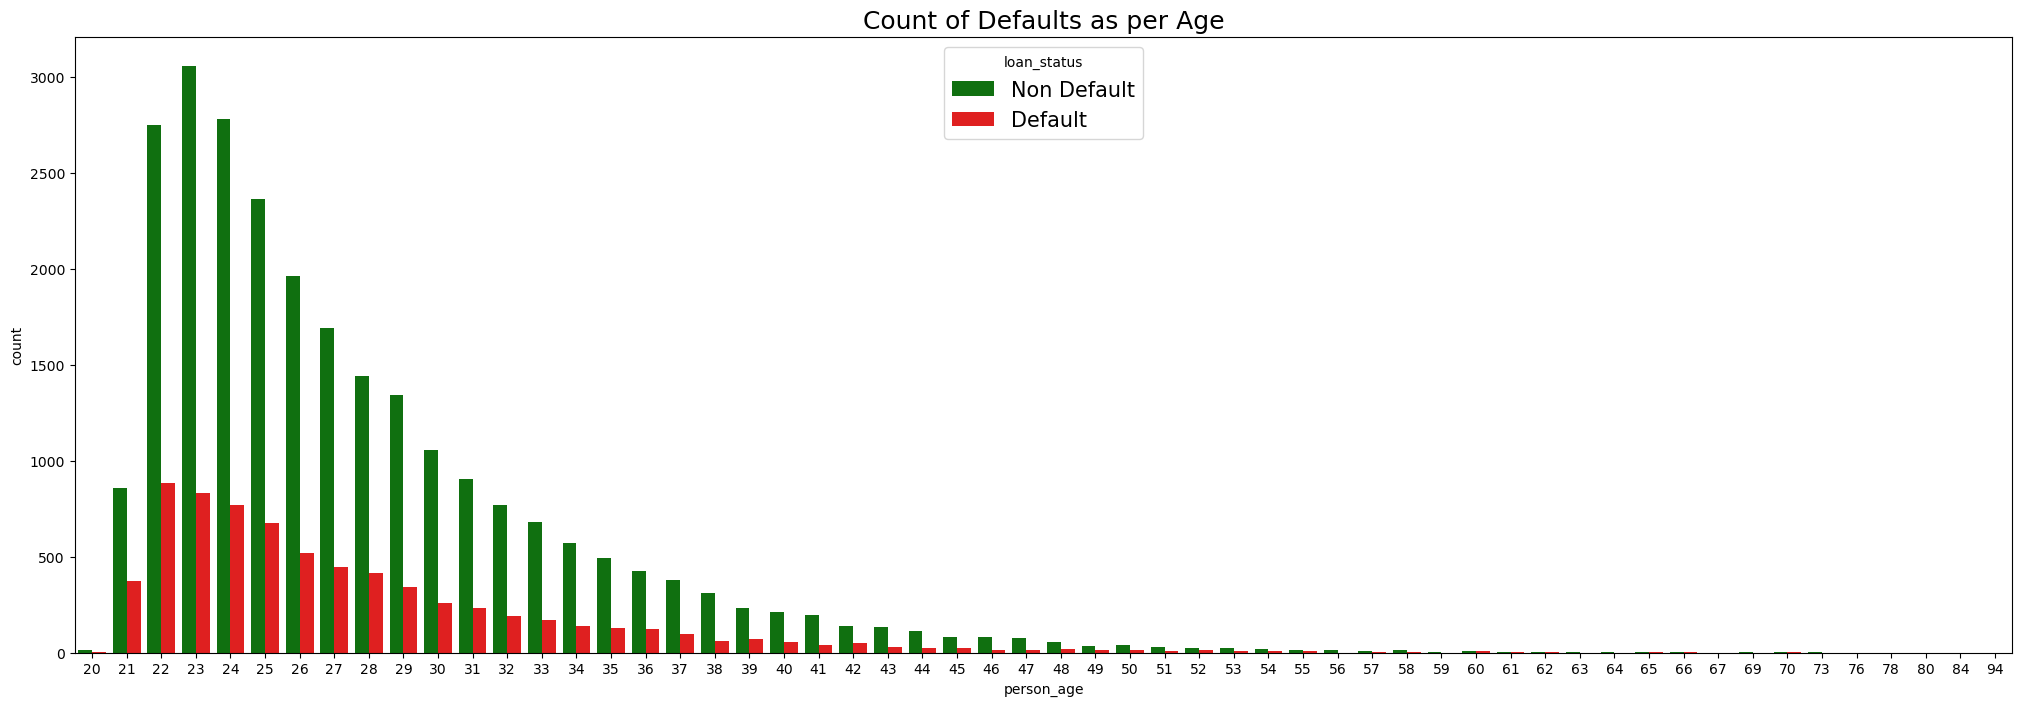

In [54]:
# count plot of Value counts in the loan Status feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(25,8)

sns.countplot(x=df_2["person_age"],hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Count of Defaults as per Age", fontsize=18)
plt.legend(title="loan_status",labels=["Non Default","Default"],fontsize=15)
plt.show()

As we can see there are more cases of Default up to the young age of 20 to 40. 
- Thus Hypothesis is `True`

#### 2) People who defults have less income than people who have not defaults - 

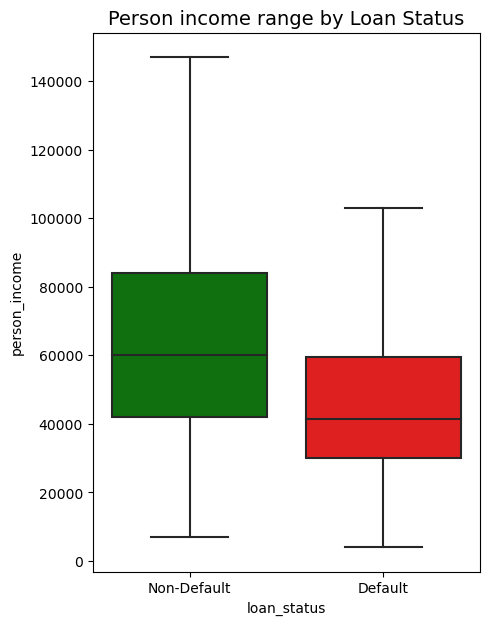

In [55]:
# Boxplot of person income and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["person_income"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Person income range by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [56]:
# Calulating Median values of person income
default = df_2[df_2["loan_status"] == 1]
nondefault = df_2[df_2["loan_status"] == 0]
print("Median of Loan Ammount for Defauts - ",default["person_income"].median())
print("Median of Loan Ammount for Non-Defauts - ",nondefault["person_income"].median())

Median of Loan Ammount for Defauts -  41496.0
Median of Loan Ammount for Non-Defauts -  60000.0


As we can see peoples who have defaults their median income(41496.0) is less than peoples who have not default(60000.0).

- Thus Hypothesis is `True`

#### 3) Mortgage have more cases of default followed by rent and own - 

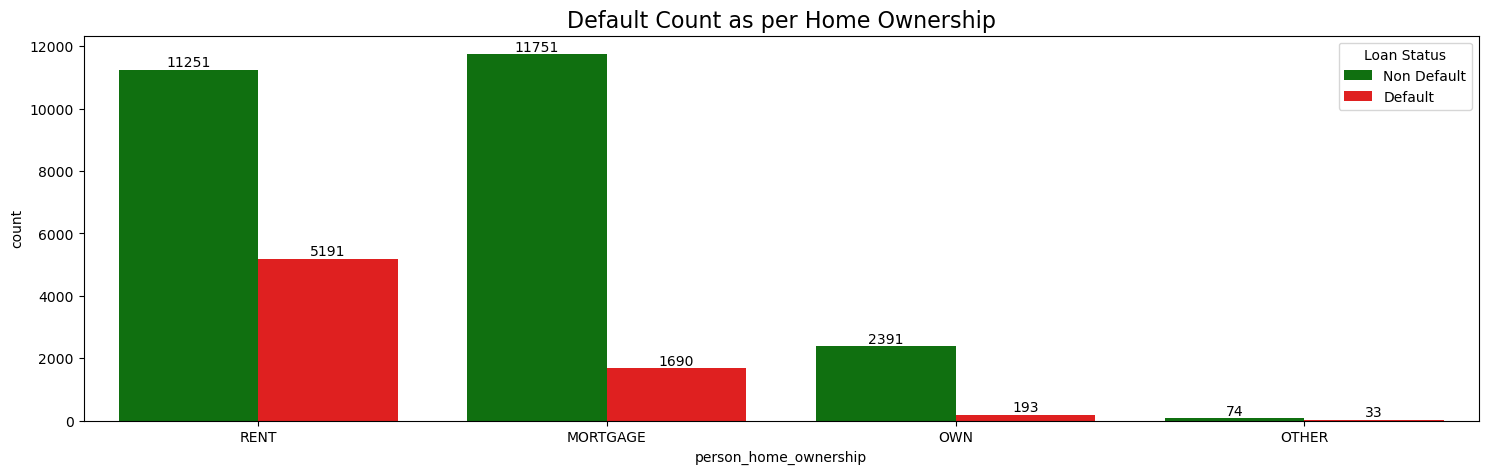

In [57]:
# countplot of Value counts in the person_home_ownership feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(18,5)

sns.countplot(x = df_2["person_home_ownership"],hue = df_2["loan_status"],
            order =df_2["person_home_ownership"].value_counts().index, palette=["g","r"])
ax.set_title("Default Count as per Home Ownership", fontsize= 16)
plt.legend(title="Loan Status", labels=["Non Default","Default"],title_fontsize=10)

for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

As we can see Default cases for rent are more and then its followed by mortgage, own and other.

Thus our Hypothesis is False
Here we are taking Alternate Hypothesis. Actually we found that there are more default on rent than mortgage.

4) There are fewer cases of default with long employment term -

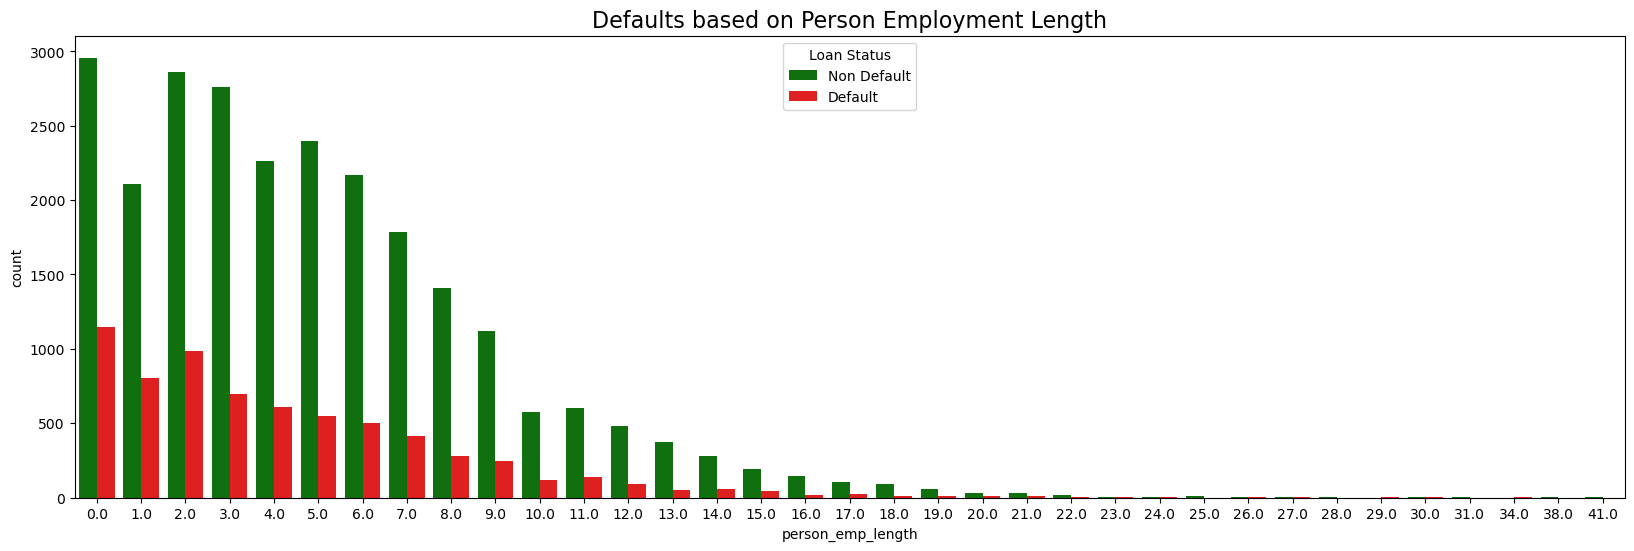

In [58]:
# countplot of Value counts in the person_emp_length feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["person_emp_length"],hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Defaults based on Person Employment Length", fontsize=16)
ax.legend(title="Loan Status", labels=["Non Default","Default"], fontsize=10)
plt.show()

we can see from the chart there are fewer cases of default with long employment length after 15 years.

- Thus our Hypothesis is `True`

#### 5) There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc. -

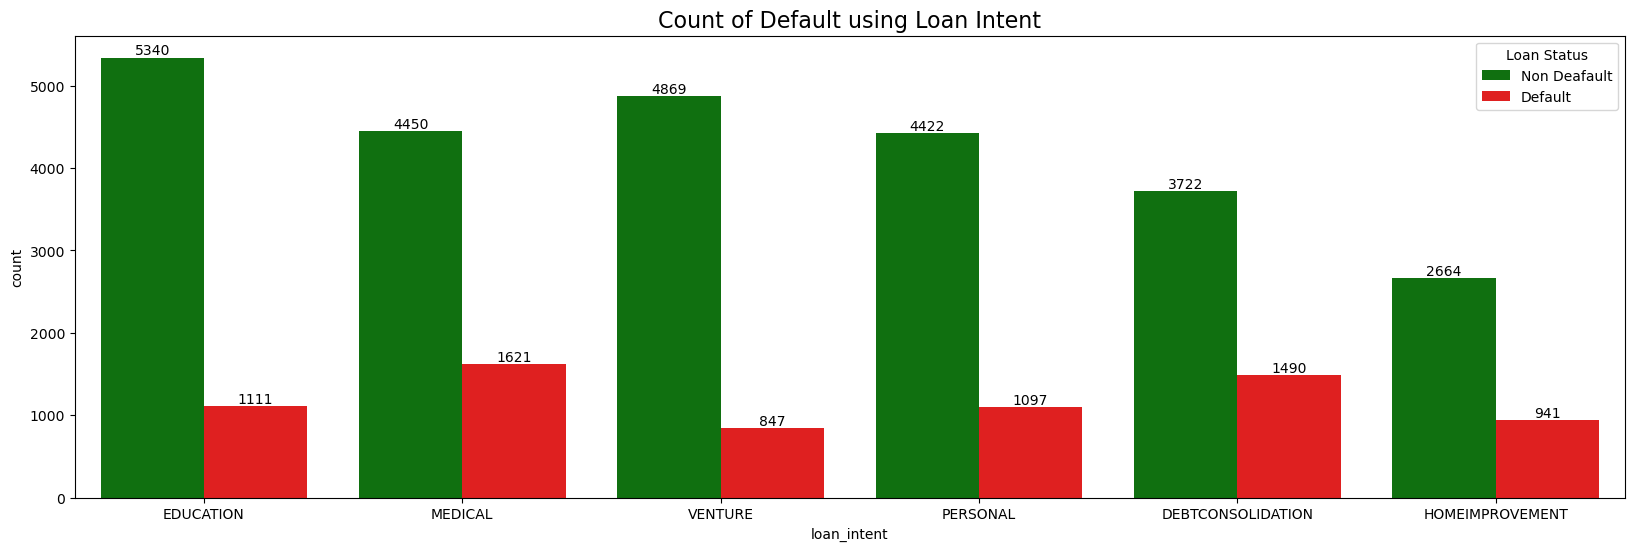

In [59]:
# countplot of Value counts in the loan_intent feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["loan_intent"], hue=df_2["loan_status"],palette=["g","r"],
             order=df_2["loan_intent"].value_counts().index)
ax.set_title("Count of Default using Loan Intent", fontsize = 16)
ax.legend(title="Loan Status", labels = ["Non Deafault","Default"], fontsize=10)
for container in ax.containers:
    ax.bar_label(container)

From above Graph There are more cases of Default for Medical Which is Followed by debt consolidation,
Education and personal case. 
- Thus Hypothesis is False.

#### 6) least cases of default for venture -

From above countplot we clearly see that Venture intent has least defaults.
- Thus Hypothesis is `True`

#### 7) The higher the grade there are fewer cases of default -

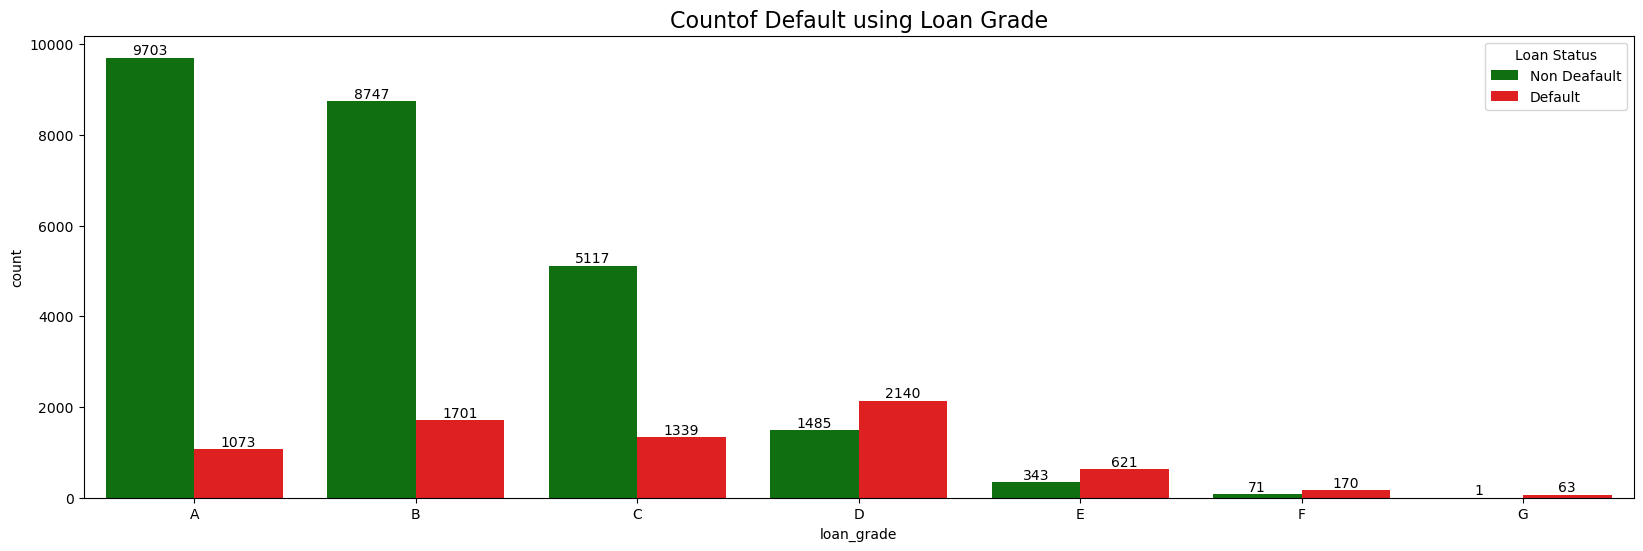

In [60]:
# countplot of Value counts in the loan_grade feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["loan_grade"], hue=df_2["loan_status"],palette=["g","r"],
             order=df_2["loan_grade"].value_counts().index)
ax.set_title("Countof Default using Loan Grade", fontsize = 16)
ax.legend(title="Loan Status", labels = ["Non Deafault","Default"], fontsize=10)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

From above graph we see that there is loan grade D has highest default but now we cannot say there are higher 
grade then cases of defaults are less.
- Thus our Hypothesis is `False`

#### 8) Median of ammount for non default is lower than median for default -

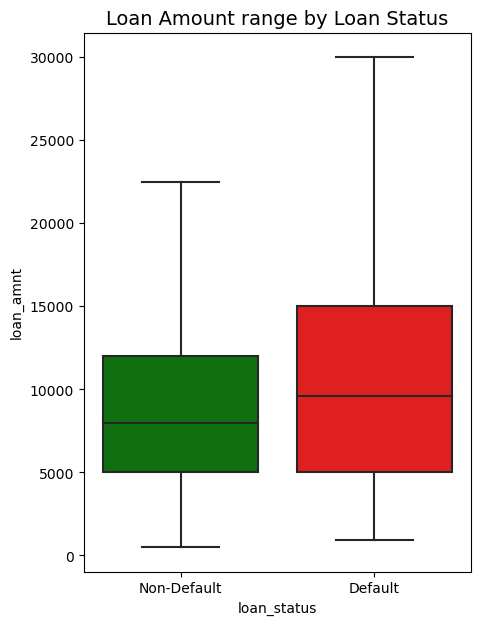

In [61]:
# Boxplot of person amount and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["loan_amnt"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Loan Amount range by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [62]:
print("Median of Loan Ammount for Defauts - ",default["loan_amnt"].median())
print("Median of Loan Ammount for Non-Defauts - ",nondefault["loan_amnt"].median())

Median of Loan Ammount for Defauts -  9600.0
Median of Loan Ammount for Non-Defauts -  8000.0


As we can see clearly median Values of Loan ammount according to loan status,Median loan ammount for defaults is Higher. 

Median of Loan Ammount for Defauts -  9600.0

Median of Loan Ammount for Non-Defauts -  8000.0

- Thus our Hypothesis is `True`

#### 9) Higher the intrest rate there are higher defaults -

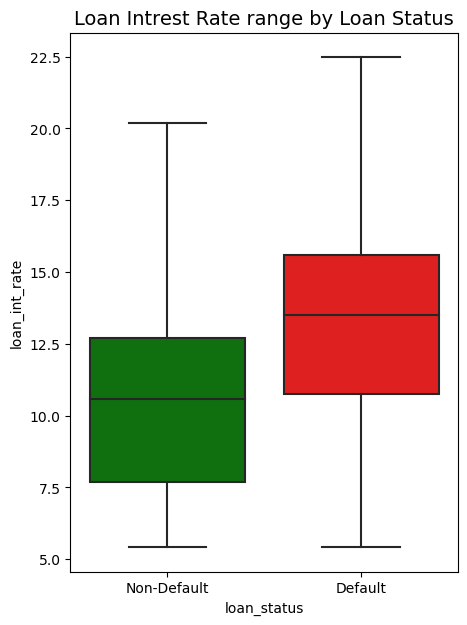

In [63]:
# Boxplot of Loan interest rate and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["loan_int_rate"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Loan Intrest Rate range by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [64]:
print("Median of Loan Intrest Rate for Defauts - ",default["loan_int_rate"].median())
print("Median of Loan Intrest Rate for Non-Defauts - ",nondefault["loan_int_rate"].median())

Median of Loan Intrest Rate for Defauts -  13.49
Median of Loan Intrest Rate for Non-Defauts -  10.59


From graph we can conclude median of interest rate is higher for defaults and lower for non defaults

Median of Loan Intrest Rate for Defauts -  13.49

Median of Loan Intrest Rate for Non-Defauts -  10.59

- Thus our Hypothesis is True.

#### 10) People who allocate higher percentage of income to the loan tend to default more than people who allocate less - 

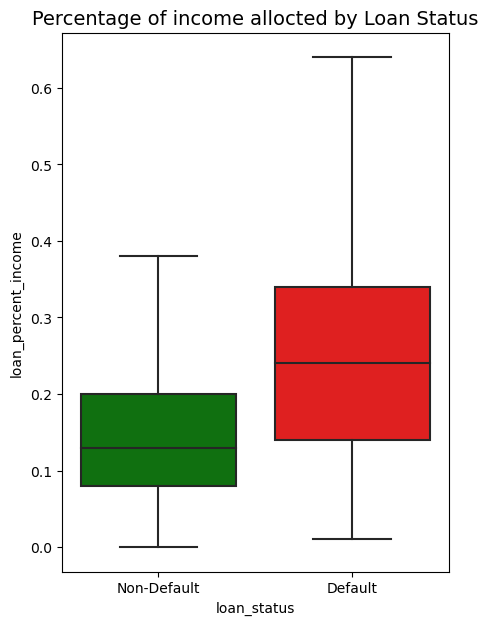

In [65]:
# Boxplot of Loan Percentage Income and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["loan_percent_income"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Percentage of income allocted by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [66]:
print("Median of Loan Percent Income for Defauts - ",default["loan_percent_income"].median())
print("Median of Loan Percent Income for Non-Defauts - ",nondefault["loan_percent_income"].median())

Median of Loan Percent Income for Defauts -  0.24
Median of Loan Percent Income for Non-Defauts -  0.13


From belove values of median of loan percent income and charts we say that people who allocate higher percent of income 
to loan they will tend to default more than people who allocate less.

Median of Loan Percent Income for Defauts -  0.24

Median of Loan Percent Income for Non-Defauts -  0.13

- Thus our Hypothesis is `True``

#### 11) There are more cases of default those have default on file -

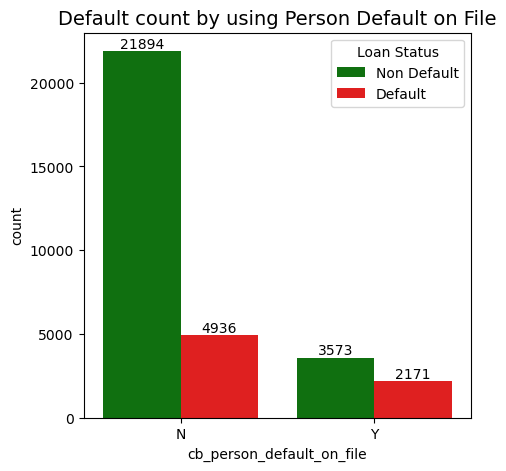

In [67]:
# Countplot of Value counts in person defaults on file feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,5)

sns.countplot(x = df_2["cb_person_default_on_file"], hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Default count by using Person Default on File", fontsize=14)
ax.legend(title="Loan Status", labels=["Non Default","Default"], fontsize=10)
for container in ax.containers:
    ax.bar_label(container)

plt.show()

From graph we can conclude that persons who dont have default on file those have more defaults.
- Thus our Hypothesis is `False` 

#### 12) There are fewer cases of default those have higher credit history length - 

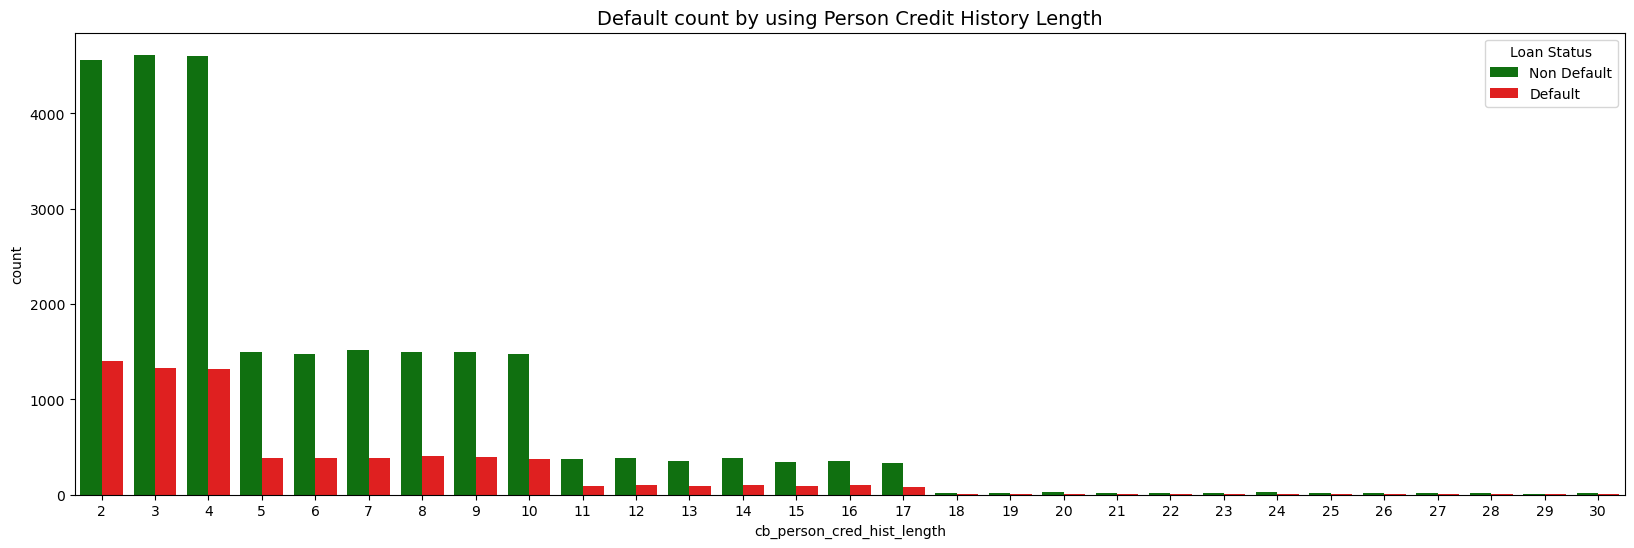

In [68]:
# Countplot of Value counts in person Credit history Length feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["cb_person_cred_hist_length"], hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Default count by using Person Credit History Length", fontsize=14)
ax.legend(title="Loan Status", labels=["Non Default","Default"], fontsize=10)

plt.show()

As Observed, there are there are fewer cases of default for people having longer credit history length.
- Thus Hypothesis is `True`

In [69]:
pd.options.display.max_colwidth = 130
result = pd.DataFrame({"ID":np.arange(1,13),
                    "Hypothesis":["More defaults for the younger peoples.",
                                  "People who defult have less income than people who have not default.",
                                  "Mortgage have more cases of default followed by rent and own.",
                                  "There are fewer people of default after long employment term.",
                                  "There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.",
                                  "Least cases of default for venture.",
                                  "The higher the grade there are fewer cases of default.",
                                  "Median of ammount for non default is lower than median for default.",
                                  "Higher the intrest rate there higher defaults.",
                                  "People who allocate higher percentage of income to the loan tend to default more than people who allocate less.",
                                  "There are more cases of default those have default on file.",
                                  "There are fewer cases of default those have higher credit history length."],
                   "Conclusion":["True","True","False","True","False","True","False","True","True","True","False","True"]})
result.set_index("ID",inplace=True)
result

,Hypothesis,Conclusion
ID,,
1,More defaults for the younger peoples.,True
2,People who defult have less income than people who have not default.,True
3,Mortgage have more cases of default followed by rent and own.,False
4,There are fewer people of default after long employment term.,True
5,"There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.",False
6,Least cases of default for venture.,True
7,The higher the grade there are fewer cases of default.,False
8,Median of ammount for non default is lower than median for default.,True
9,Higher the intrest rate there higher defaults.,True
